In [1]:
! pip install tensorflow_addons

In [2]:
import os.path
import numpy as np

#Ensures we use Tensorflow 1.x
#%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow_addons as tfa
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

from google.colab import files
import pandas as pd
from sklearn.linear_model import LinearRegression
from astropy.stats import median_absolute_deviation
import numpy as np
from sklearn.linear_model import Ridge

2.5.0


In [ ]:
print(tf.__version__)

2.5.0


In [3]:
! git clone https://github.com/zdebeurs/rv_net

fatal: destination path 'rv_net' already exists and is not an empty directory.


In [4]:
# rv_net imports.
import sys
sys.path.append("rv_net/")
from ops import training
from tf_util import config_util
from tf_util import configdict
from tf_util import estimator_runner
from rv_net import data_HARPS_N
from rv_net import  data, rv_model, estimator_util, load_dataset_ridge, ridge_regress_harps
#from ridge_regress_harps import ridge_regress_harps
#from load_dataset_ridge import load_dataset_ridge

In [5]:
# Or get the files from Google Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## Reading in the data (June 29, 2021)





In [6]:
crossval= False# True #False, "yes" 

In [7]:
# Change this path to point towards the location of the files in your drive
!ls 'gdrive/Shared drives/Exoplanet_RV/Clean_June28_rv_net_code/TF_record_July_10_21_no_planets_v2'#Data Products for Chris Leet/HARPS-N Solar Telescope Data (using old DRS)'

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `ls 'gdrive/Shared drives/Exoplanet_RV/Clean_June28_rv_net_code/TF_record_July_10_21_no_planets_v2'#Data Products for Chris Leet/HARPS-N Solar Telescope Data (using old DRS)''


In [8]:
# Read in files for cross-validation
DATA_DIR = 'gdrive/Shared drives/Exoplanet_RV/Clean_June28_rv_net_code/TF_record_July_10_21_no_planets_v2'

if crossval:
  data_files = tf.data.Dataset.list_files(DATA_DIR+'*cross_val*',shuffle=False)
  data_files = [t.numpy() for t in data_files]
  TRAIN_FILE_NAME_LIST = []
  VAL_FILE_NAME_LIST = []

  N = len(data_files)
  for i in range(N):
    val_files = [data_files[i]]
    #print(val_files)
    VAL_FILE_NAME_LIST.append(val_files)
    train_files = data_files[0:i] + data_files[i+1:]
    TRAIN_FILE_NAME_LIST.append(train_files)
    # add all the training files

  NUM_TRAINING_EXAMPLES = 503
  NUM_VALIDATION_EXAMPLES = 51

else:
  TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
  VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_test")]]#test")]]

  NUM_TRAINING_EXAMPLES = 503
  NUM_VALIDATION_EXAMPLES = 61

In [9]:
print(TRAIN_FILE_NAME_LIST)
VAL_FILE_NAME_LIST

[['gdrive/Shared drives/Exoplanet_RV/Clean_June28_rv_net_code/TF_record_July_10_21_no_planets_v2/TF_ccf_full_train']]


[['gdrive/Shared drives/Exoplanet_RV/Clean_June28_rv_net_code/TF_record_July_10_21_no_planets_v2/TF_ccf_test']]

In [10]:
# @title Data loader
def _example_parser(serialized_example):
    """Parses a single tf.Example into feature and label tensors."""
    feature_name = "Rescaled CCF_residuals" #CCF_residuals
    label_name = "activity signal"#"RV",
    label2_name = "BJD"
    data_fields = {
        feature_name: tf.io.FixedLenFeature([161], tf.float32),
        label_name: tf.io.FixedLenFeature([], tf.float32),
        label2_name: tf.io.FixedLenFeature([], tf.float32),
    }
    parsed_fields = tf.io.parse_single_example(serialized_example, features=data_fields)
    return parsed_fields[feature_name], parsed_fields[label_name]*1000, parsed_fields[label2_name]

#def load_dataset(file_pattern, batch_size, mode=tf.estimator.ModeKeys.EVAL):
#  filename_dataset = tf.data.Dataset.list_files(file_pattern)
#  dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)
#  if mode == tf.estimator.ModeKeys.TRAIN:
#    dataset = dataset.shuffle(buffer_size=NUM_TRAINING_EXAMPLES)
#  dataset = dataset.map(_example_parser, num_parallel_calls=4)
#  dataset = dataset.batch(batch_size)
#  return dataset

def load_dataset(filenames, batch_size, mode=tf.estimator.ModeKeys.EVAL):
  filename_dataset = tf.data.Dataset.from_tensor_slices(filenames)
  dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(buffer_size=NUM_TRAINING_EXAMPLES)
  dataset = dataset.map(_example_parser, num_parallel_calls=4)
  dataset = dataset.batch(batch_size)
  return dataset

In [11]:
# @title Define LinearModel, FCModel, CNNModel
class LinearModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(LinearModel, self).__init__()
        self.hparams = hparams
        #self.weights = tf.Variable(tf.zeros(self.hparams.num_features))
        self.dense_layer = tf.keras.layers.Dense(
            1, kernel_initializer=tf.zeros_initializer, use_bias=False)
        
    def call(self, features, training=False):
      # return tf.tensordot(features, self.weights, axes=1)
      return tf.squeeze(self.dense_layer(features))

class FCModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(FCModel, self).__init__()
        self.hparams = hparams
        #self.hidden_layer1 = tf.keras.layers.Dense(
        #    self.hparams.num_dense_units, activation=tf.keras.activations.relu)
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, training=False):
      net = tf.expand_dims(features, -1)
      batch_size, length, depth = net.shape
      net = tf.reshape(net, [batch_size, length*depth])
      for dense in self.dense_layers:
        net = dense(net)
      net = self.output_layer(net)
      return tf.squeeze(net)

# @title Define RVLinearModel
class CNNModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(CNNModel, self).__init__()
        self.hparams = hparams
        self.conv_layers = [
          tf.keras.layers.Conv1D(
              filters=hparams.num_conv_filters, 
              kernel_size=hparams.conv_kernel_size,
              activation=tf.keras.activations.relu,
              padding="same")
          for i in range(hparams.num_conv_layers)
        ]
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, training=False):
      net = tf.expand_dims(features, -1)
      for conv in self.conv_layers:
        net = conv(net)
      batch_size, length, depth = net.shape
      net = tf.reshape(net, [batch_size, length*depth])
      for dense in self.dense_layers:
        net = dense(net)
      net = self.output_layer(net)
      return tf.squeeze(net)

In [12]:
def make_predictions(model, dataset):
  all_preds = []
  all_labels = []
  all_bjds = []
  for features, labels, bjds in dataset:
    preds = model(features, training=False)
    all_preds.append(preds.numpy())
    all_labels.append(labels.numpy())
    all_bjds.append(bjds.numpy())
  return np.concatenate(all_labels), np.concatenate(all_preds), np.concatenate(all_bjds)

def train(model, hparams, plots, model_name, num_epochs=100):
  train_dataset = load_dataset([TRAIN_FILE_NAME], batch_size=hparams.batch_size, mode=tf.estimator.ModeKeys.TRAIN)
  val_dataset = load_dataset([VAL_FILE_NAME], batch_size=min(1024, NUM_VALIDATION_EXAMPLES), mode=tf.estimator.ModeKeys.EVAL)
  loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
  Opt = tfa.optimizers.extend_with_decoupled_weight_decay(tf.optimizers.SGD)
  optimizer = Opt(weight_decay=hparams.weight_decay, learning_rate=hparams.learning_rate, momentum=hparams.momentum)
  metrics = [
             tf.keras.metrics.MeanSquaredError("train_loss"),
             tf.keras.metrics.RootMeanSquaredError("train_rmse")
  ]
  weight_decay_list_t.append(hparams.weight_decay)
  gaussian_noise_list_t.append(hparams.gaussian_noise_scale)

  metric_values = []
  for epoch in range(1, num_epochs+1):
    # Reset metric values for each new epoch.
    for m in metrics:
      m.reset_states()

    # Train over all batches in the training set.
    for features, labels, bjds in train_dataset:
      if hparams.gaussian_noise_scale:
        features += tf.random.normal(features.shape, stddev=hparams.gaussian_noise_scale)
        #print(hparams.gaussian_noise_scale)
      # One training step.
      with tf.GradientTape() as t:
        preds = model(features, training=True)
        loss = loss_fn(labels, preds)
      grads = t.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      # Update the metrics.
      for m in metrics:
        m(labels, preds)
    
    # End of an epoch.
    epoch_metrics = {"epoch": epoch}
    # First, log the training metrics.
    for m in metrics:
      epoch_metrics[m.name] = m.result().numpy()
    # Next, evaluate over the validation set.
    labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
    epoch_metrics["val_rmse"] = np.sqrt(np.mean(np.square(preds_val - labels_val)))
    # Print metric values at selected epochs.
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
      print("{epoch}: Train loss: {train_loss:.4}, Train RMSE: {train_rmse:.4}, Val RMSE: {val_rmse:.4}".format(**epoch_metrics))
    metric_values.append(epoch_metrics)

  # Gather predictions
  labels, preds, bjd = make_predictions(model, train_dataset)
  labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
  all_bjds_val.append(bjd_val)
  bjd_run_val.append(bjd_val)
  all_pred_val.append(preds_val)
  pred_run_val.append(preds_val)
  all_labels_val.append(labels_val)
  labels_run_val.append(labels_val)

  # Scatter reduction plot
  sd_x = np.std(labels_val, ddof=1)
  rms_x = np.sqrt(np.mean(np.square(labels_val - preds_val)))
  rms_x_list.append(rms_x)
  rms_avg_list.append(rms_x)
  stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
  x_range = np.linspace(-4,5.5, 17)
  upper_bound = x_range+rms_x
  lower_bound = x_range-rms_x

  if plots=="ON":
    fig, axes = plt.subplots(1, 2, figsize=(24, 6))
    ax = axes[0]
    ax.plot([m["train_rmse"] for m in metric_values], label="Train RMSE")
    ax.plot([m["val_rmse"] for m in metric_values], label="Validation RMSE")
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper right")

    # Gather predictions to plot against labels.
    ax = axes[1]
    ax.plot(preds, labels, ".", label="Training")
    ax.plot(preds_val, labels_val, ".", label="Validation")
    ax.set_xlabel("Actual Y")
    ax.set_ylabel("Predicted Y")
    ax.legend(loc="lower right")

    # plot the scatter reduction plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(labels_val, preds_val, ".")
    ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
    #ax.plot(x_range,z[0]*x_range+z[1], color="blue")
    rms_fill=rms_x#0.15
    ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                    alpha=0.5, label="1 standard deviation")
    ax1.set_xlim(-4, 4);
    ax1.set_ylim(-4, 4);
    ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
    ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
    ax1.set_title(model_name+" Model Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
    #hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
    textstr = '\n'.join((
        r'Raw scatter=%.3f m/s' % (sd_x, ),
        r'Corrected scatter=%.3f m/s' % (rms_x, ),
        r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
    ax1.text(-3.8, 3.5, textstr, size=15,
            ha="left", va="top",
            bbox=dict(boxstyle="square",
                      ec=(1., 0.5, 0.5),
                      fc=(1., 0.8, 0.8),
                      ))
    ax1.legend(loc="lower right")
  else:
    textstr = '\n'.join((
        r'Raw scatter=%.3f m/s' % (sd_x, ),
        r'Corrected scatter=%.3f m/s' % (rms_x, ),
        r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
    print(textstr)
    
    
  

## Linear Model Run

1: Train loss: 2.387, Train RMSE: 1.545, Val RMSE: 1.513
10: Train loss: 1.923, Train RMSE: 1.387, Val RMSE: 1.456
20: Train loss: 1.65, Train RMSE: 1.285, Val RMSE: 1.36
30: Train loss: 1.6, Train RMSE: 1.265, Val RMSE: 1.355
40: Train loss: 1.559, Train RMSE: 1.249, Val RMSE: 1.366
45: Train loss: 1.542, Train RMSE: 1.242, Val RMSE: 1.353
________________________
Cross-val number: 1, Run number: 1
1: Train loss: 2.387, Train RMSE: 1.545, Val RMSE: 1.513
10: Train loss: 1.923, Train RMSE: 1.387, Val RMSE: 1.456
20: Train loss: 1.65, Train RMSE: 1.285, Val RMSE: 1.36
30: Train loss: 1.6, Train RMSE: 1.265, Val RMSE: 1.355
40: Train loss: 1.559, Train RMSE: 1.249, Val RMSE: 1.366
45: Train loss: 1.542, Train RMSE: 1.242, Val RMSE: 1.353
________________________
Cross-val number: 1, Run number: 2
1: Train loss: 2.387, Train RMSE: 1.545, Val RMSE: 1.513
10: Train loss: 1.923, Train RMSE: 1.387, Val RMSE: 1.456
20: Train loss: 1.65, Train RMSE: 1.285, Val RMSE: 1.36
30: Train loss: 1.6, Tr

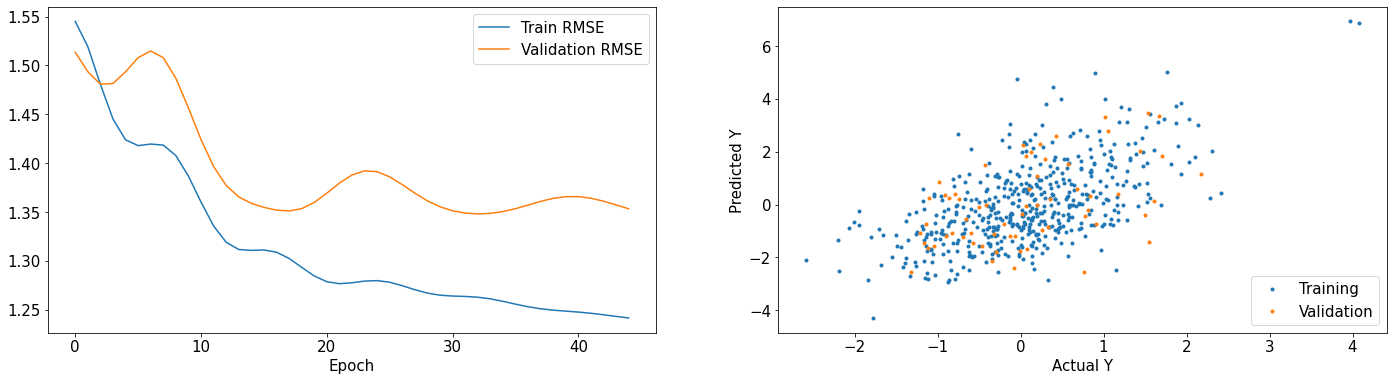

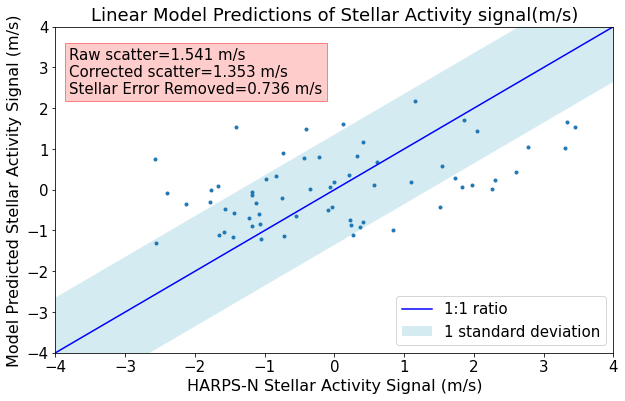

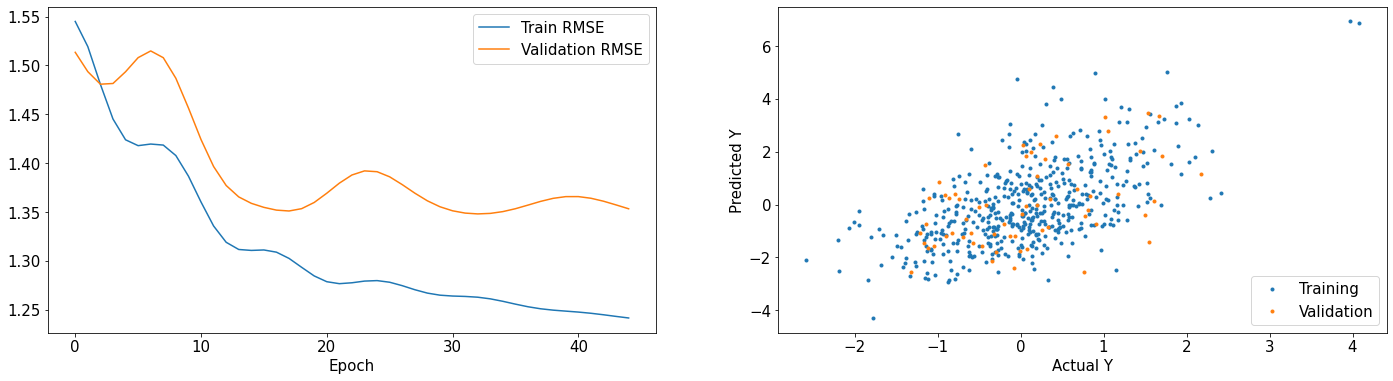

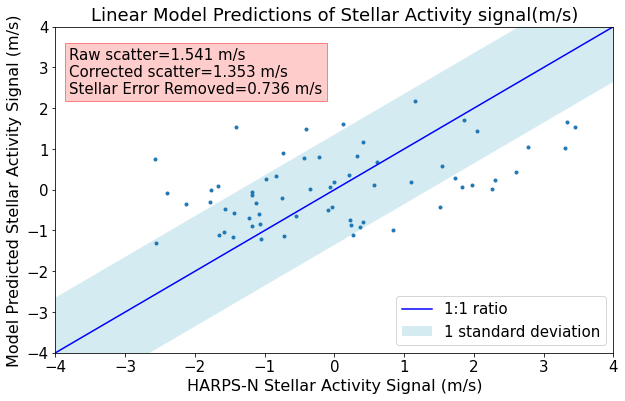

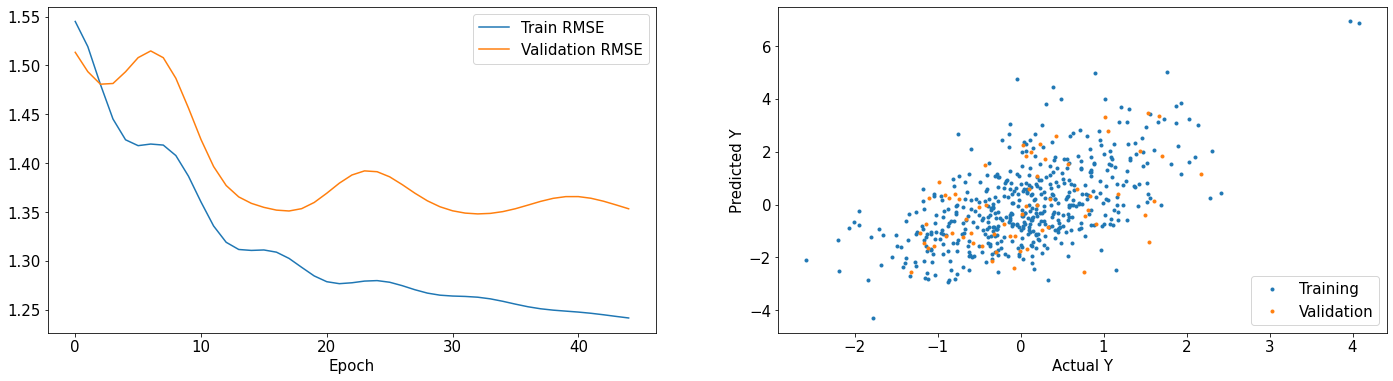

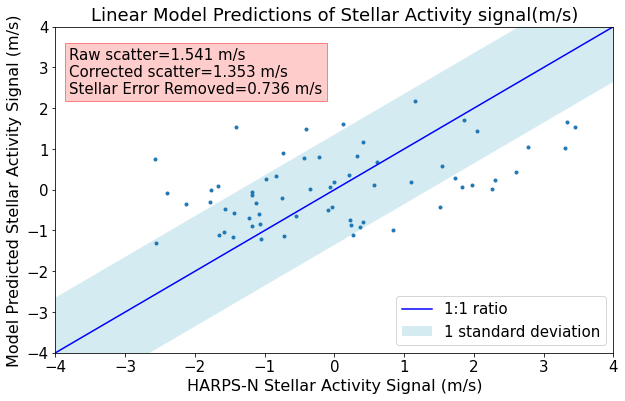

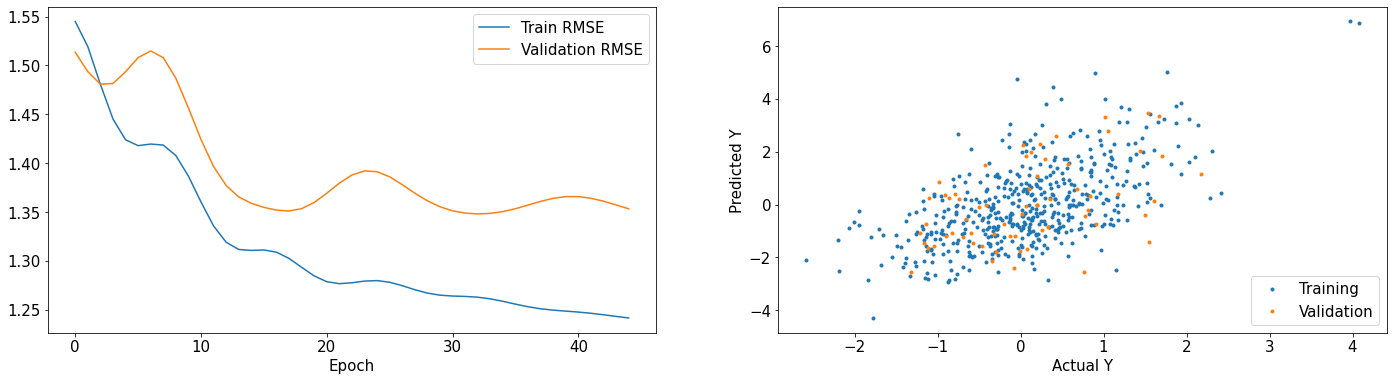

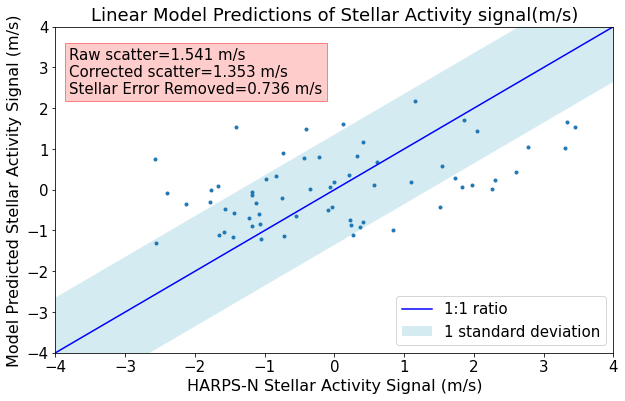

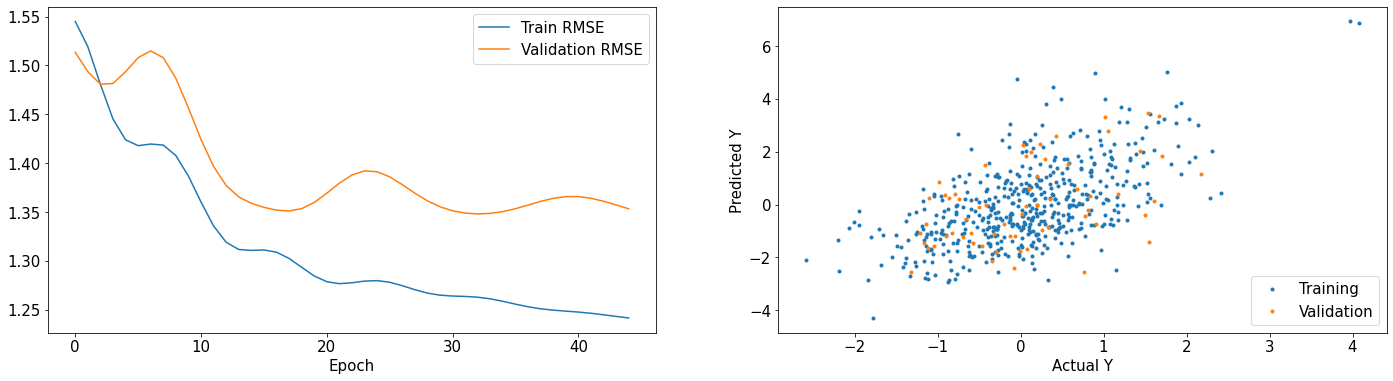

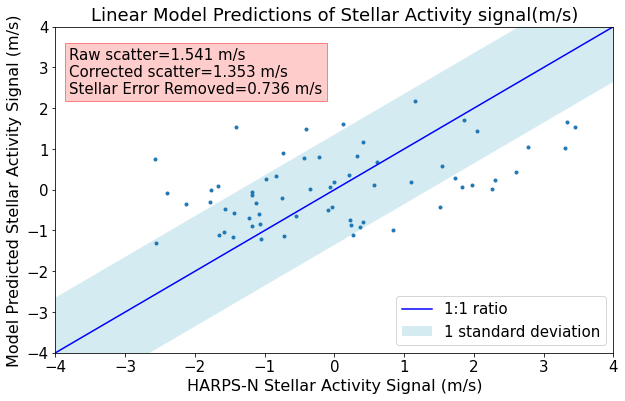

In [13]:
  # Linear NN Model run

  # Cross validation Linear NN Model Run (10 times)


  rms_avg_list = []
  weight_decay_list_t = []
  gaussian_noise_list_t = []
  rms_x_list = []

  all_bjds_val = []
  all_pred_val = []
  all_labels_val = []
  all_mean_val_preds = []
  all_mean_val_bjds = []
  all_mean_val_labels = []
  all_mean_val_bjds = []

  for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    bjd_run_val = []
    pred_run_val = []
    labels_run_val = []
    for k in range(0,5):#10): #should be 10 for a full run
      hparams = configdict.ConfigDict(dict(
          num_features=401,
          learning_rate=1e-3,
          momentum=0.9,
          batch_size=1024,
          weight_decay=1e-5, 
          gaussian_noise_scale=0, 
      ))
      model = LinearModel(hparams)
      train(model, hparams, plots="ON", model_name = "Linear", num_epochs=45)
      print(model)
      print("________________________")
      print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
    mean_val_preds = np.mean(pred_run_val, axis=0)
    mean_val_labels = np.mean(labels_run_val, axis=0)
    mean_val_bjds = np.mean(bjd_run_val, axis=0)
    all_mean_val_preds.append(mean_val_preds.tolist())
    all_mean_val_labels.append(mean_val_labels.tolist())
    all_mean_val_bjds.append(mean_val_bjds.tolist())
  avg = np.mean(rms_avg_list)
  print("________________________")
  print(avg)

labels: sd: 1.5405963699066159
corrected rv: sd: 1.3620924643354253
____________________________________________
labels: MAD*1.4826: 1.627187119424343
corrected rv: MAD*1.4826: 1.4396617986202238
____________________________________________
labels: 68 percent/2: 1.6474647498130799
corrected rv: 68 percent/2: 1.4676239681243897


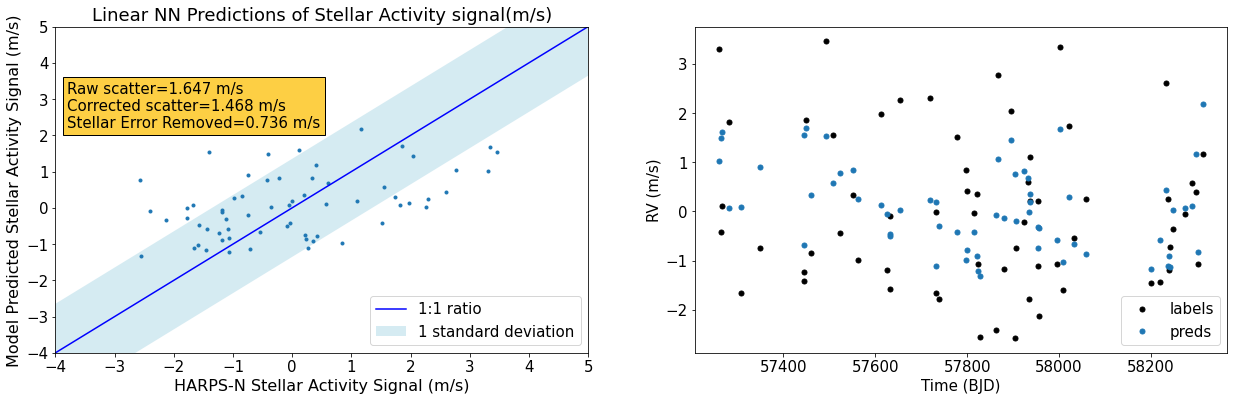

In [ ]:
df = pd.DataFrame(list(zip(all_mean_val_labels[0],all_mean_val_preds[0], all_mean_val_bjds[0])), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_linearNN_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("Linear NN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
    r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 3.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")

## Ridge Regression


In [ ]:
def load_dataset_ridge(filename):
  dataset_hparams = configdict.ConfigDict(dict(
    ccf_feature_name="Rescaled CCF_residuals", #CCF_residuals
    label_feature_name= "activity signal",#"RV",
    label_feature_name2= "BJD",
    batch_size=300,
    label_rescale_factor=1000,
  ))
  dataset = data_HARPS_N.DatasetBuilder(filename, dataset_hparams, tf.estimator.ModeKeys.EVAL)()
  batches = list(dataset)
  ccf_data, labels, bjds = zip(*[(batch["ccf_data"], batch["label"], batch["bjd"]) for batch in batches])
  ccf_data = np.concatenate(ccf_data)
  labels = np.concatenate(labels)
  bjds = np.concatenate(bjds)
  assert len(ccf_data.shape) == 2
  assert len(labels.shape) == 1
  assert len(bjds.shape) == 1
  assert ccf_data.shape[0] == labels.shape[0]
  print("Read dataset with {} examples".format(labels.shape[0]))
  return ccf_data, labels, bjds

In [ ]:
def ridge_regress_harps(TRAIN_FILE_NAME_LIST, VAL_FILE_NAME_LIST, alpha, verbose):
  rms_avg_list = []
  weight_decay_list_t = []
  gaussian_noise_list_t = []
  rms_x_list = []

  all_bjds_val = []
  all_pred_val = []
  all_labels_val = []
  all_mean_val_preds = []
  all_mean_val_bjds = []
  all_mean_val_labels = []
  all_mean_val_bjds = []

  for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    train_X, train_Y, train_bjd  = load_dataset_ridge(TRAIN_FILE_NAME)
    val_X, val_Y, val_bjd = load_dataset_ridge(VAL_FILE_NAME)

    pred_run_val = []
    labels_run_val = []
    bjd_run_val = []
    for k in range(0,10):
      model = Ridge(alpha=alpha).fit(train_X, train_Y)
      val_pred_Y = model.predict(val_X)
      pred_run_val.append(val_pred_Y)
      labels_run_val.append(val_Y)
      bjd_run_val.append(val_bjd)
      rms_avg = np.sqrt(np.mean(np.square(val_Y -val_pred_Y)))
      rms_avg_list.append(rms_avg)
      if verbose == True:
        print(model)
        print("________________________")
        print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
        print("rms: "+str(rms_avg))
      else:
        continue
    mean_val_preds = np.mean(pred_run_val, axis=0)
    mean_val_labels = np.mean(labels_run_val, axis=0)
    mean_val_bjds = np.mean(bjd_run_val, axis=0)
    all_mean_val_preds.append(mean_val_preds.tolist())
    all_mean_val_labels.append(mean_val_labels.tolist())
    all_mean_val_bjds.append(mean_val_bjds.tolist())
  avg = np.mean(rms_avg_list)
  print("________________________")
  print("average rms = "+str(avg)+" m/s")

  #flatten the lists
  all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
  all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
  all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]
  
  return all_mean_val_preds, all_mean_val_labels, all_mean_val_bjds

In [ ]:
# Cross validation Ridge Regression Model Run (10 times)

all_mean_val_preds, all_mean_val_labels, all_mean_val_bjds = ridge_regress_harps(TRAIN_FILE_NAME_LIST, 
                                                                                 VAL_FILE_NAME_LIST, 
                                                                                 alpha=9.469, 
                                                                                 verbose=False)

Read dataset with 503 examples
Read dataset with 63 examples
________________________
average rms = 1.2503327 m/s


labels: sd: 1.540596345087198
corrected rv: sd: 1.2600761680864798
____________________________________________
labels: MAD*1.4826: 1.627187119424343
corrected rv: MAD*1.4826: 1.042080160063505
____________________________________________
labels: 68 percent/2: 1.6474647450447082
corrected rv: 68 percent/2: 1.2985150563716887


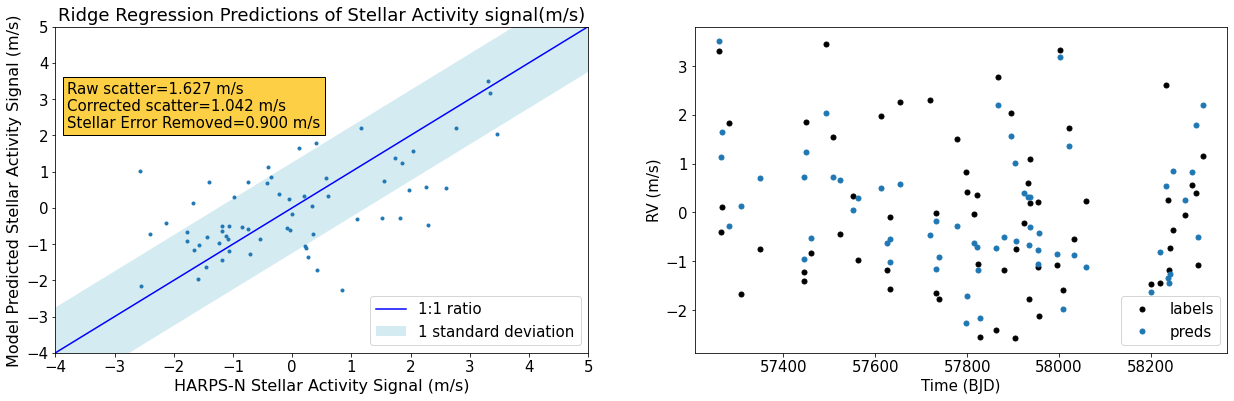

In [ ]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_ridge_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("Ridge Regression Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (labels_median_absolute_deviation_norm, ),
    r'Corrected scatter=%.3f m/s' % (corrected_rvs_median_absolute_deviation_norm, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 3.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")

## FC NN Model Run

In [14]:
  # FC NN Model run

  # Cross validation Linear NN Model Run (10 times)
  rms_avg_list = []
  weight_decay_list_t = []
  gaussian_noise_list_t = []
  rms_x_list = []

  all_bjds_val = []
  all_pred_val = []
  all_labels_val = []
  all_mean_val_preds = []
  all_mean_val_bjds = []
  all_mean_val_labels = []
  all_mean_val_bjds = []

  for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    bjd_run_val = []
    pred_run_val = []
    labels_run_val = []
    for k in range(0,10): #should be 10 for a full run
      hparams = configdict.ConfigDict(dict(
          num_features=161,
          learning_rate=0.0016077,
          momentum=0.9,
          batch_size=300,
          num_dense_units=200,
          num_dense_layers=4,
          weight_decay=0.00010000, #5e-4, #7e-2,
          gaussian_noise_scale=0,#1.5, 
      ))
      model = FCModel(hparams)
      train(model, hparams, plots="OFF",model_name="FC NN", num_epochs=50)
      print(model)
      print("________________________")
      print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
    mean_val_preds = np.mean(pred_run_val, axis=0)
    mean_val_labels = np.mean(labels_run_val, axis=0)
    mean_val_bjds = np.mean(bjd_run_val, axis=0)
    all_mean_val_preds.append(mean_val_preds.tolist())
    all_mean_val_labels.append(mean_val_labels.tolist())
    all_mean_val_bjds.append(mean_val_bjds.tolist())
  avg = np.mean(rms_avg_list)
  print("________________________")
  print(avg)

  #flatten the lists
  all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
  all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
  all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]

1: Train loss: 2.342, Train RMSE: 1.544, Val RMSE: 1.57
10: Train loss: 1.762, Train RMSE: 1.349, Val RMSE: 1.483
20: Train loss: 1.429, Train RMSE: 1.2, Val RMSE: 1.394
30: Train loss: 1.192, Train RMSE: 1.103, Val RMSE: 1.345
40: Train loss: 0.9956, Train RMSE: 1.009, Val RMSE: 1.316
50: Train loss: 0.8495, Train RMSE: 0.912, Val RMSE: 1.316
Raw scatter=1.541 m/s
Corrected scatter=1.316 m/s
Stellar Error Removed=0.802 m/s
________________________
Cross-val number: 1, Run number: 1
1: Train loss: 2.295, Train RMSE: 1.52, Val RMSE: 1.523
10: Train loss: 1.747, Train RMSE: 1.325, Val RMSE: 1.431
20: Train loss: 1.364, Train RMSE: 1.177, Val RMSE: 1.376
30: Train loss: 1.146, Train RMSE: 1.075, Val RMSE: 1.346
40: Train loss: 0.947, Train RMSE: 0.9692, Val RMSE: 1.356
50: Train loss: 0.7345, Train RMSE: 0.8561, Val RMSE: 1.362
Raw scatter=1.541 m/s
Corrected scatter=1.362 m/s
Stellar Error Removed=0.721 m/s
________________________
Cross-val number: 1, Run number: 2
1: Train loss: 2.413,

labels: sd: 1.540596345087198
corrected rv: sd: 1.3173255648226971
____________________________________________
labels: MAD*1.4826: 1.627187119424343
corrected rv: MAD*1.4826: 1.2886208967626094
____________________________________________
labels: 68 percent/2: 1.6474647450447082
corrected rv: 68 percent/2: 1.2134786850214003


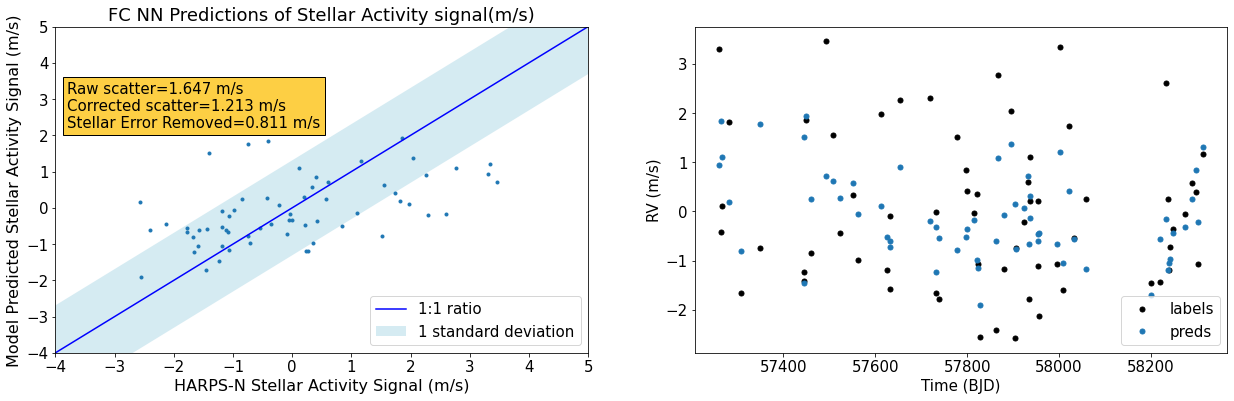

In [16]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_FCNN_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("FC NN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
    r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 3.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")

## CNN Model Run

In [17]:
# CNN Model run

# Cross validation CNN Model Run (10 times)
rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []
all_mean_val_bjds = []

for index in range(0, len(VAL_FILE_NAME_LIST)):
  TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
  VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
  bjd_run_val = []
  pred_run_val = []
  labels_run_val = []
  for k in range(0,10): #should be 10 for a full run
    hparams = configdict.ConfigDict(dict(
        num_features=161,
        learning_rate=0.0050618, #1e-3,
        momentum=0.9,
        batch_size=300,
        conv_kernel_size=3,
        num_conv_filters=32,
        num_conv_layers=4,
        num_dense_units=500,
        num_dense_layers=1,
        weight_decay=0.0012341, #5e-4, #7e-2,
        gaussian_noise_scale=0,#1.5,
    ))
    model = CNNModel(hparams)
    train(model, hparams, plots="OFF",model_name="CNN", num_epochs=34)#65)
    print(model)
    print("________________________")
    print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
  mean_val_preds = np.mean(pred_run_val, axis=0)
  mean_val_labels = np.mean(labels_run_val, axis=0)
  mean_val_bjds = np.mean(bjd_run_val, axis=0)
  all_mean_val_preds.append(mean_val_preds.tolist())
  all_mean_val_labels.append(mean_val_labels.tolist())
  all_mean_val_bjds.append(mean_val_bjds.tolist())
avg = np.mean(rms_avg_list)
print("________________________")
print(avg)

#flatten the lists
all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]

1: Train loss: 2.327, Train RMSE: 1.543, Val RMSE: 1.53
10: Train loss: 1.784, Train RMSE: 1.331, Val RMSE: 1.457
20: Train loss: 1.47, Train RMSE: 1.208, Val RMSE: 1.307
30: Train loss: 1.242, Train RMSE: 1.115, Val RMSE: 1.28
34: Train loss: 1.089, Train RMSE: 1.043, Val RMSE: 1.241
Raw scatter=1.541 m/s
Corrected scatter=1.241 m/s
Stellar Error Removed=0.912 m/s
________________________
Cross-val number: 1, Run number: 1
1: Train loss: 2.445, Train RMSE: 1.546, Val RMSE: 1.518
10: Train loss: 1.803, Train RMSE: 1.342, Val RMSE: 1.434
20: Train loss: 1.401, Train RMSE: 1.192, Val RMSE: 1.295
30: Train loss: 1.15, Train RMSE: 1.076, Val RMSE: 1.212
34: Train loss: 1.204, Train RMSE: 1.088, Val RMSE: 1.217
Raw scatter=1.541 m/s
Corrected scatter=1.217 m/s
Stellar Error Removed=0.945 m/s
________________________
Cross-val number: 1, Run number: 2
1: Train loss: 2.43, Train RMSE: 1.543, Val RMSE: 1.515
10: Train loss: 1.866, Train RMSE: 1.371, Val RMSE: 1.402
20: Train loss: 1.454, Train

labels: sd: 1.540596345087198
corrected rv: sd: 1.236923719523864
____________________________________________
labels: MAD*1.4826: 1.627187119424343
corrected rv: MAD*1.4826: 1.1745854148499666
____________________________________________
labels: 68 percent/2: 1.6474647450447082
corrected rv: 68 percent/2: 1.2059305986762048


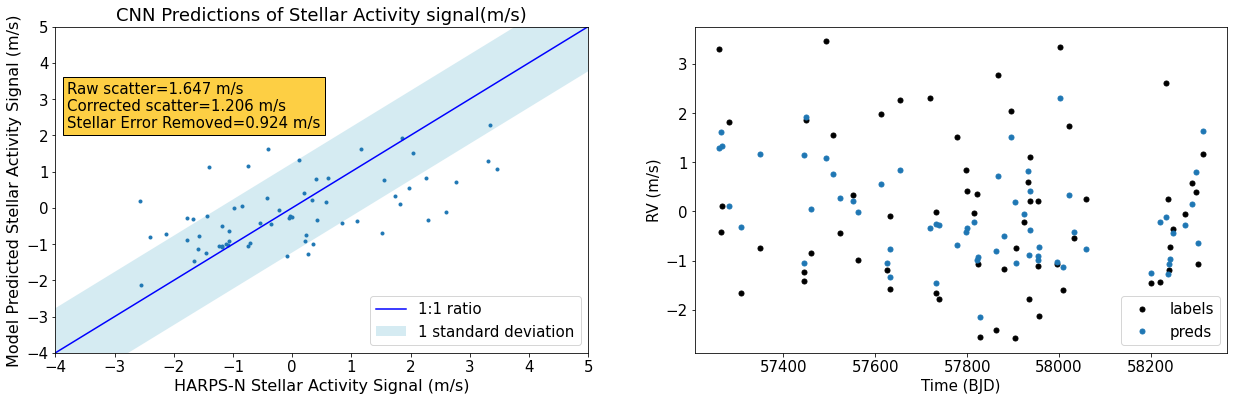

In [18]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_CNN_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("CNN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
    r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 3.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")

## TF_Record_Reader

To read in a tf_record in this way, you must "factory reset the runtime" so that Tensorflow 1.0 can be loaded

In [ ]:
#Ensures we use Tensorflow 1.x
%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()

TensorFlow 1.x selected.


In [ ]:
# Or get the files from Google Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!ls 'gdrive/Shared drives/Exoplanet_RV/Data Products for Chris Leet/HARPS-N Solar Telescope Data (using old DRS)/'

TF_ccf_cross_val0  TF_ccf_cross_val4  TF_ccf_cross_val8  TF_ccf_val
TF_ccf_cross_val1  TF_ccf_cross_val5  TF_ccf_cross_val9
TF_ccf_cross_val2  TF_ccf_cross_val6  TF_ccf_full_train
TF_ccf_cross_val3  TF_ccf_cross_val7  TF_ccf_test


In [ ]:
cross_val_BJD_list = []
val_BJD_list = []
test_BJD_list = []
ccf_rescaled_list = []
ccf_list = []
rv_activity_list = []


path_name = 'gdrive/Shared drives/Exoplanet_RV/Data Products for Chris Leet/HARPS-N Solar Telescope Data (using old DRS)/TF_ccf_test'
record_iterator = tf.io.tf_record_iterator(path=path_name)
for string_record in record_iterator:
        example = tf.train.Example()
        example.ParseFromString(string_record)
        edict = dict(example.features.feature)
        cross_val_BJD_list.append(edict['BJD'].float_list.value[0])
        
        # These are the CCFs that we used. They are normalized by subtracting the mean and dividing by the SD
        ccf_rescaled = edict['Rescaled CCF_residuals'].float_list.value
        ccf_rescaled_list.append(ccf_rescaled)
        ccf = edict['CCF_residuals'].float_list.value
        ccf_list.append(ccf)

        # This is the stellar activity signal that we used. All planets are removed from this signal.
        rv_activity_list.append(edict['activity signal'].float_list.value[0]*1000) #convert to m/s
        #print(example)
print(len(cross_val_BJD_list))

AttributeError: ignored

In [ ]:
BJD_list_p3 = cross_val_BJD_list.copy()
BJD_list_p1
BJD_list_p2

[57617.05859375,
 58188.015625,
 58068.078125,
 58272.03515625,
 57598.0703125,
 58242.02734375,
 57413.03515625,
 58248.03125,
 57328.08203125,
 57621.0546875,
 57965.05078125,
 58209.0078125,
 57567.0390625,
 57869.015625,
 57880.01953125,
 58163.01953125,
 57594.0234375,
 57237.05078125,
 58223.01953125,
 57418.03125,
 57897.0,
 58030.0390625,
 57322.08203125,
 57279.1171875,
 57561.04296875,
 57471.04296875,
 57271.0625,
 58212.01953125,
 57608.04296875,
 58009.078125,
 57849.01171875,
 57673.07421875,
 57910.0390625,
 57867.9609375,
 58025.1328125,
 57475.015625,
 57349.0703125,
 57987.0625,
 57459.015625,
 58298.04296875,
 58060.07421875,
 57351.0703125,
 57257.05859375,
 57503.0234375,
 57294.00390625,
 58015.07421875,
 57850.0390625,
 57546.0390625,
 57592.05078125,
 57329.078125,
 57778.99609375,
 57683.0703125,
 57632.05859375,
 57968.0546875,
 57958.05078125,
 58316.05078125,
 57650.0703125,
 57562.04296875,
 57510.0234375,
 58222.01953125,
 57888.0,
 57995.0625,
 57429.0195

In [ ]:
# @title Load data from other notebook

bjd_other = [57233.055, 57234.05 , 57235.055, 57236.05 , 57237.05 , 57238.05 ,
       57239.055, 57239.996, 57242.06 , 57252.06 , 57253.02 , 57254.035,
       57255.082, 57256.06 , 57257.06 , 57259.14 , 57260.043, 57261.062,
       57262.05 , 57263.06 , 57264.062, 57265.062, 57266.066, 57267.066,
       57268.062, 57269.05 , 57270.062, 57271.062, 57274.117, 57275.105,
       57276.086, 57278.023, 57279.117, 57280.047, 57281.03 , 57282.066,
       57283.062, 57284.043, 57286.094, 57293.035, 57294.004, 57302.08 ,
       57303.066, 57304.08 , 57306.082, 57307.08 , 57308.082, 57322.082,
       57324.062, 57325.08 , 57326.074, 57328.082, 57329.08 , 57330.082,
       57331.082, 57333.08 , 57334.08 , 57335.082, 57341.086, 57345.047,
       57347.074, 57348.074, 57349.07 , 57350.074, 57351.07 , 57352.094,
       57353.062, 57354.074, 57355.074, 57359.098, 57368.035, 57369.066,
       57372.055, 57378.06 , 57379.06 , 57380.06 , 57381.03 , 57382.055,
       57384.09 , 57385.06 , 57386.055, 57387.05 , 57388.05 , 57391.062,
       57394.047, 57396.07 , 57397.05 , 57398.043, 57399.043, 57400.047,
       57405.035, 57408.04 , 57409.043, 57410.008, 57411.016, 57413.035,
       57414.055, 57415.035, 57418.03 , 57419.027, 57422.023, 57424.055,
       57426.027, 57426.992, 57428.027, 57429.02 , 57430.05 , 57431.023,
       57432.008, 57433.023, 57434.047, 57435.02 , 57436.023, 57440.074,
       57440.98 , 57444.01 , 57445.016, 57446.016, 57446.992, 57448.016,
       57449.016, 57451.01 , 57452.008, 57453.016, 57454.01 , 57455.016,
       57456.992, 57457.96 , 57459.016, 57461.984, 57463.016, 57464.97 ,
       57468.035, 57470.01 , 57471.043, 57472.01 , 57472.992, 57473.996,
       57475.016, 57476.07 , 57477.004, 57480.027, 57483.02 , 57485.02 ,
       57486.043, 57487.016, 57488.02 , 57489.02 , 57491.02 , 57492.027,
       57493.01 , 57494.08 , 57498.074, 57499.016, 57501.03 , 57502.   ,
       57503.023, 57506.   , 57507.082, 57508.027, 57509.023, 57510.023,
       57512.043, 57514.   , 57520.004, 57522.027, 57523.03 , 57524.016,
       57525.027, 57526.027, 57527.027, 57528.062, 57529.03 , 57531.   ,
       57532.03 , 57532.99 , 57534.023, 57535.035, 57536.027, 57538.03 ,
       57539.027, 57540.035, 57541.06 , 57542.004, 57543.035, 57544.066,
       57545.008, 57546.04 , 57547.04 , 57548.04 , 57549.04 , 57550.04 ,
       57551.08 , 57552.01 , 57553.01 , 57554.027, 57556.047, 57557.05 ,
       57558.016, 57560.016, 57561.043, 57562.043, 57563.043, 57564.01 ,
       57565.043, 57566.05 , 57567.04 , 57568.043, 57569.062, 57582.05 ,
       57585.05 , 57586.1  , 57588.05 , 57589.05 , 57590.05 , 57591.05 ,
       57592.05 , 57594.023, 57595.04 , 57596.05 , 57597.055, 57598.07 ,
       57599.05 , 57600.05 , 57601.027, 57602.055, 57603.055, 57605.055,
       57606.055, 57607.047, 57608.043, 57609.055, 57610.062, 57612.06 ,
       57613.082, 57614.06 , 57617.06 , 57618.06 , 57619.066, 57620.06 ,
       57621.055, 57622.055, 57623.06 , 57624.062, 57625.062, 57626.062,
       57627.082, 57628.062, 57629.062, 57630.07 , 57631.066, 57632.06 ,
       57633.062, 57634.062, 57635.086, 57636.062, 57637.062, 57638.066,
       57639.06 , 57640.066, 57641.133, 57642.066, 57643.07 , 57644.07 ,
       57645.1  , 57646.07 , 57647.066, 57648.07 , 57649.047, 57650.07 ,
       57651.07 , 57652.07 , 57653.07 , 57654.07 , 57655.074, 57656.062,
       57657.066, 57658.074, 57659.074, 57661.07 , 57662.082, 57663.07 ,
       57664.086, 57665.062, 57666.066, 57668.08 , 57671.074, 57672.08 ,
       57673.074, 57674.074, 57675.07 , 57676.008, 57679.08 , 57680.062,
       57682.082, 57683.07 , 57691.08 , 57692.082, 57693.047, 57699.094,
       57702.055, 57703.08 , 57704.08 , 57705.1  , 57706.055, 57709.074,
       57710.08 , 57712.074, 57717.074, 57719.07 , 57720.06 , 57721.07 ,
       57723.066, 57728.07 , 57729.07 , 57731.07 , 57732.062, 57733.066,
       57736.035, 57737.066, 57738.062, 57739.062, 57741.07 , 57749.055,
       57750.055, 57756.08 , 57757.055, 57760.03 , 57763.047, 57766.027,
       57769.062, 57770.074, 57772.035, 57773.04 , 57775.01 , 57777.035,
       57778.035, 57778.996, 57788.027, 57789.027, 57790.027, 57791.023,
       57792.023, 57793.023, 57797.984, 57800.06 , 57802.02 , 57805.03 ,
       57807.016, 57808.016, 57809.03 , 57810.01 , 57811.02 , 57812.016,
       57813.02 , 57814.02 , 57815.01 , 57816.023, 57817.02 , 57818.016,
       57819.02 , 57820.023, 57821.008, 57822.008, 57823.004, 57823.984,
       57826.004, 57829.004, 57836.016, 57837.016, 57838.957, 57840.016,
       57841.004, 57843.   , 57844.066, 57845.01 , 57846.02 , 57848.03 ,
       57849.01 , 57850.04 , 57851.02 , 57853.02 , 57854.043, 57856.016,
       57857.023, 57860.016, 57861.016, 57862.023, 57865.023, 57866.04 ,
       57867.027, 57867.96 , 57869.016, 57875.066, 57876.027, 57877.027,
       57879.027, 57880.02 , 57881.023, 57882.047, 57887.03 , 57888.   ,
       57892.047, 57893.02 , 57895.03 , 57896.03 , 57897.   , 57898.03 ,
       57899.074, 57900.03 , 57901.035, 57901.992, 57903.98 , 57905.043,
       57906.035, 57907.035, 57908.035, 57909.035, 57910.04 , 57911.035,
       57913.04 , 57917.047, 57920.04 , 57921.02 , 57922.035, 57923.04 ,
       57924.043, 57925.047, 57926.043, 57927.043, 57928.04 , 57929.043,
       57931.035, 57932.043, 57933.043, 57934.043, 57935.047, 57936.043,
       57937.047, 57938.11 , 57939.04 , 57940.05 , 57941.047, 57942.043,
       57942.984, 57944.047, 57946.047, 57948.047, 57950.047, 57952.047,
       57953.05 , 57954.047, 57955.04 , 57956.05 , 57957.023, 57958.05 ,
       57959.05 , 57962.055, 57963.055, 57964.055, 57965.05 , 57968.055,
       57969.035, 57970.05 , 57971.055, 57972.055, 57975.062, 57978.06 ,
       57979.062, 57984.09 , 57986.06 , 57987.062, 57989.03 , 57991.035,
       57992.066, 57994.06 , 57995.062, 57996.062, 57997.047, 57999.062,
       58000.062, 58001.023, 58002.11 , 58003.04 , 58003.98 , 58005.062,
       58006.07 , 58007.07 , 58008.06 , 58009.08 , 58013.066, 58014.06 ,
       58015.074, 58017.08 , 58018.094, 58021.082, 58022.062, 58023.035,
       58025.133, 58026.05 , 58027.07 , 58029.066, 58030.04 , 58031.07 ,
       58032.08 , 58033.08 , 58034.066, 58035.055, 58036.066, 58037.07 ,
       58038.074, 58042.086, 58044.086, 58045.09 , 58046.04 , 58047.06 ,
       58049.117, 58052.066, 58057.08 , 58058.11 , 58060.074, 58061.094,
       58067.08 , 58068.08 , 58163.02 , 58164.023, 58165.023, 58171.043,
       58171.992, 58178.97 , 58186.01 , 58188.016, 58189.02 , 58190.016,
       58191.977, 58194.016, 58194.98 , 58197.04 , 58197.953, 58199.004,
       58200.02 , 58201.016, 58202.01 , 58205.06 , 58207.008, 58209.008,
       58211.016, 58212.02 , 58214.016, 58215.027, 58216.016, 58217.03 ,
       58219.004, 58220.047, 58221.047, 58222.02 , 58223.02 , 58224.023,
       58225.023, 58226.035, 58227.02 , 58233.074, 58234.   , 58235.03 ,
       58235.977, 58237.023, 58238.023, 58239.027, 58240.004, 58242.027,
       58243.027, 58245.066, 58245.996, 58247.04 , 58248.03 , 58248.98 ,
       58252.03 , 58253.066, 58254.008, 58255.027, 58256.04 , 58257.03 ,
       58258.03 , 58259.03 , 58260.035, 58266.1  , 58268.035, 58270.06 ,
       58271.04 , 58272.035, 58274.04 , 58275.055, 58276.03 , 58277.035,
       58278.04 , 58280.04 , 58281.04 , 58282.04 , 58283.094, 58284.04 ,
       58285.04 , 58287.043, 58289.047, 58290.04 , 58291.043, 58292.008,
       58293.047, 58294.043, 58295.03 , 58296.043, 58297.043, 58298.043,
       58299.082, 58300.043, 58301.043, 58302.055, 58303.043, 58304.047,
       58306.062, 58307.035, 58308.047, 58311.047, 58312.03 , 58313.08 ,
       58314.055, 58315.047, 58316.05 , 58317.035, 58318.01 ]

In [ ]:
all_bjds = BJD_list_p1 + BJD_list_p2 + BJD_list_p3
sorted_all_bjds = np.sort(np.array(all_bjds))

df = pd.DataFrame(list(zip(sorted_all_bjds, sorted_all_bjds)), 
               columns =['old_bjds', 'new_bjds']) 

#if bjd_other == sorted_all_bjds:
#    print ("The lists are identical")
#else :
#    print ("The lists are not identical")

for i in np.arange(0, 629):
  if round(df['old_bjds'][i], 2) != round(df['new_bjds'][1], 2):
    print(str(df['old_bjds'][i])+" : "+str(df['new_bjds'][i]))

57233.0546875 : 57233.0546875
57235.0546875 : 57235.0546875
57236.05078125 : 57236.05078125
57237.05078125 : 57237.05078125
57238.05078125 : 57238.05078125
57239.0546875 : 57239.0546875
57239.99609375 : 57239.99609375
57242.05859375 : 57242.05859375
57252.05859375 : 57252.05859375
57253.01953125 : 57253.01953125
57254.03515625 : 57254.03515625
57255.08203125 : 57255.08203125
57256.05859375 : 57256.05859375
57257.05859375 : 57257.05859375
57259.140625 : 57259.140625
57260.04296875 : 57260.04296875
57261.0625 : 57261.0625
57262.05078125 : 57262.05078125
57263.05859375 : 57263.05859375
57264.0625 : 57264.0625
57265.0625 : 57265.0625
57266.06640625 : 57266.06640625
57267.06640625 : 57267.06640625
57268.0625 : 57268.0625
57269.05078125 : 57269.05078125
57270.0625 : 57270.0625
57271.0625 : 57271.0625
57274.1171875 : 57274.1171875
57275.10546875 : 57275.10546875
57276.0859375 : 57276.0859375
57278.0234375 : 57278.0234375
57279.1171875 : 57279.1171875
57280.046875 : 57280.046875
57281.03125 : 

In [ ]:
print(len(BJD_list_p1))
len(BJD_list_p1 + BJD_list_p2 + BJD_list_p3)

503


629

In [ ]:
all_bjds

[57233.0546875,
 57234.05078125,
 57235.0546875,
 57236.05078125,
 57237.05078125,
 57238.05078125,
 57239.0546875,
 57239.99609375,
 57242.05859375,
 57252.05859375,
 57253.01953125,
 57254.03515625,
 57255.08203125,
 57256.05859375,
 57257.05859375,
 57259.140625,
 57260.04296875,
 57261.0625,
 57262.05078125,
 57263.05859375,
 57264.0625,
 57265.0625,
 57266.06640625,
 57267.06640625,
 57268.0625,
 57269.05078125,
 57270.0625,
 57271.0625,
 57274.1171875,
 57275.10546875,
 57276.0859375,
 57278.0234375,
 57279.1171875,
 57280.046875,
 57281.03125,
 57282.06640625,
 57283.0625,
 57284.04296875,
 57286.09375,
 57293.03515625,
 57294.00390625,
 57302.078125,
 57303.06640625,
 57304.078125,
 57306.08203125,
 57307.078125,
 57308.08203125,
 57322.08203125,
 57324.0625,
 57325.078125,
 57326.07421875,
 57328.08203125,
 57329.078125,
 57330.08203125,
 57331.08203125,
 57333.078125,
 57334.078125,
 57335.08203125,
 57341.0859375,
 57345.046875,
 57347.07421875,
 57348.07421875,
 57349.07031